In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision as tv
import os
import cv2 as cv

# Creating a model dataset and the corresponding ground truth

In [3]:
class ImgImgDataset(Dataset):
    '''When ground and reference images are in image formats.'''
    def __init__(self, img_dir, gnd_dir, transform=None, target_transform=None):
        
        self.img_dir = img_dir
        self.gnd_dir = gnd_dir
        
        def get_file_names(path):
            all_files = os.listdir(path)
            accepted_filetypes = ('tif', 'tiff', 'png', 'jpg', 'jpeg', 'bmp')
            file_names = [f for f in all_files if all_files.rpartition('.')[2] in accepted_filetypes]
            return file_names
        
        self.img_labels = get_file_names(img_dir)
        self.gnd_dir = get_file_names(gnd_dir)
        self.transform = transform # Note to self: probably should use bicubic interpolation to resize the images to a smaller size
        self.target_transform = target_transform # Note to self: probably should use bicubic interpolation to resize the ground truth images to a smaller size
        
    def __len__(self):
        return len(self_img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        img = cv.imread(img_path, cv.IMREAD_UNCHANGED).to(torch.float16)
        img = tv.ToTensor()(image)
        
        gnd_path = os.path.join(self.gnd_dir, self.img_labels[idx])
        gnd = cv.imread(gnd_path, cv.IMREAD_UNCHANGED).to(torch.float16)
        gnd = tv.ToTensor()(gnd)
        
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            gnd = self.target_transform(gnd)
        
        return img, gnd

In [4]:
class ptptDataset(Dataset):
    def __init__(self, img_dir, gnd_dir, transform=None, target_transform=None):
        
        self.img_dir = img_dir
        self.gnd_dir = gnd_dir
        
        def get_file_names(path):
            all_files = os.listdir(path)
            accepted_filetypes = ('pt')
            file_names = [f for f in all_files if all_files.rpartition('.')[2] in accepted_filetypes]
            return file_names
        
        self.img_labels = get_file_names(img_dir)
        self.gnd_dir = get_file_names(gnd_dir)
        self.transform = transform # Note to self: probably should use bicubic interpolation to resize the images to a smaller size
        self.target_transform = target_transform # Note to self: probably should use bicubic interpolation to resize the ground truth images to a smaller size
        
    def __len__(self):
        return len(self_img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        img = torch.load(img_path).to(torch.float16)
        
        gnd_path = os.path.join(self.gnd_dir, self.img_labels[idx])
        gnd = torch.load(gnd_path).to(torch.float16)
        
        if img.is_sparse:
            img = img.to_dense() # Convolutional layers don't support sparse tensors
        
        if gnd.is_sparse:
            gnd = gnd.to_dense() # Convolutional layers don't support sparse tensors
        
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            gnd = self.target_transform(gnd)
        
        return img, gnd

# Creating the DataLoader class

In [ ]:
train_dataloader = Dataloader(training_data, batch_size=5, shuffle=True)
test_dataloader = Dataloader(test_data, batch_size=5, shuffle=True)

# FFT Convolution PyTorch Class

In [5]:
# Cool dependencies
from typing import Tuple, Union, Iterable
import warnings
from functools import partial

# Import dependencies
from torch.fft import fftn, ifftn, ifftshift
from torch import nn, Tensor
import torch
import gc

In [6]:
def fft_conv(
    signal: Tensor,
    kernel: Tensor,
    bias: Tensor = None,
    padding: Union[int, Iterable[int], str] = 0,
    padding_mode: str = "constant",
    stride: Union[int, Iterable[int]] = 1,
    dilation: Union[int, Iterable[int]] = 1,
    groups: int = 1,
) -> Tensor:
    
    """
    Performs N-D convolution of tensors using FFTs, which is very fast for large kernel sizes. Can also add a bias term, just like a normal convolution layer.

    Args:
        signal: (Tensor) Input tensor to be convolved with the kernel.
        kernel: (Tensor) Convolution kernel.
        bias: (Tensor) Bias tensor to add to the output.
        padding: (Union[int, Iterable[int], str) If int, Number of zero samples to pad then input on the last dimension. If str, "same" supported to pad input for size preservation.
        padding_mode: (str) Padding mode to use from {constant, reflection, replication}. Reflection is not not available for 3D.
        stride: (Union[int, Iterable[int]) Stride size for computing output values.
        dilation: (Union[int, Iterable[int]) Dilation rate for the kernel.
        groups: (int) Number of groups for the convolution.

    Returns:
        (Tensor) Convolution result tensor
    """

    # Cast padding, stride & dilation to tuples.
    n = signal.ndim - 2
    
    stride_ = to_ntuple(stride, n=n)
    dilation_ = to_ntuple(dilation, n=n)
    
    if isinstance(padding, str):
        if padding == "same":
            if stride != 1 or dilation != 1:
                raise ValueError("stride must be 1 for padding='same'.")
            padding_ = [(k - 1) / 2 for k in kernel.shape[2:]]
        else:
            raise ValueError(f"Padding mode {padding} not supported.")
    else:
        padding_ = to_ntuple(padding, n=n)

    # internal dilation offsets
    offset = torch.zeros(1, 1, *dilation_, device=signal.device, dtype=signal.dtype)
    offset[(slice(None), slice(None), *((0,) * n))] = 1.0

    # correct the kernel by cutting off unwanted dilation trailing zeros
    cutoff = tuple(slice(None, -d + 1 if d != 1 else None) for d in dilation_)

    # pad the kernel internally according to the dilation parameters
    kernel = torch.kron(kernel, offset)[(slice(None), slice(None)) + cutoff]

    # Pad the input signal & kernel tensors (round to support even sized convolutions)
    signal_padding = [r(p) for p in padding_[::-1] for r in (floor, ceil)]
    signal = nn.functional.pad(signal, signal_padding, mode=padding_mode)

    # Because PyTorch computes a *one-sided* FFT, we need the final dimension to
    # have *even* length.  Just pad with one more zero if the final dimension is odd.
    
    signal_size = signal.size()  # original signal size without padding to even
    
    if signal.size(-1) % 2 != 0:
        signal = nn.functional.pad(signal, [0, 1])

    kernel_padding = [
        pad
        for i in reversed(range(2, signal.ndim))
        for pad in [0, signal.size(i) - kernel.size(i)]
    ]
    padded_kernel = f.pad(kernel, kernel_padding)

    # Perform fourier convolution -- FFT, matrix multiply, then IFFT
    signal_fr = rfftn(signal.float(), dim=tuple(range(2, signal.ndim)))
    kernel_fr = rfftn(padded_kernel.float(), dim=tuple(range(2, signal.ndim)))

    kernel_fr.imag *= -1
    output_fr = torch.mul(signal_fr, kernel_fr) # signal_fr, kernel_fr, groups = groups
    output = irfftn(output_fr, dim=tuple(range(2, signal.ndim)))

    # Remove extra padded values
    crop_slices = [slice(None), slice(None)] + [
        slice(0, (signal_size[i] - kernel.size(i) + 1), stride_[i - 2])
        for i in range(2, signal.ndim)
    ]
    output = output[crop_slices].contiguous()

    # Optionally, add a bias term before returning.
    if bias is not None:
        bias_shape = tuple([1, -1] + (signal.ndim - 2) * [1])
        output += bias.view(bias_shape)

    return output

In [1]:
# Cool dependencies
from typing import Tuple, Union, Iterable
import warnings
from functools import partial
from math import floor, ceil

# Import dependencies
from torch.fft import fftn, ifftn, ifftshift, fftshift, rfftn, irfftn
from torch import mul, abs, nn, Tensor
from torch.nn import functional as f
import gc

## Defining FFT Convolution Definition
def fftconv(
    signal: Tensor,
    kernel: Tensor,
    bias: Tensor = None,
    padding: Union[int, Iterable[int], str] = 0,
    padding_mode: str = "constant",
    stride: Union[int, Iterable[int]] = 1,
    dilation: Union[int, Iterable[int]] = 1,
    groups: int = 1,
) -> Tensor:
    n = signal.ndim - 2
    if type(stride) == int:
        stride = (stride,) * n
    if type(stride[0]) != int:
        # Make sure tuple only contains integers
        kernel_size = tuple(int(k) for k in kernel_size)
    if type(dilation) == int:
        dilation = (dilation,) * n
    if type(dilation[0]) != int:
        # Make sure tuple only contains integers
        dilation = tuple(int(d) for d in dilation)

    if isinstance(padding, str):
        if padding == "same":
            if (1 not in stride) or (1 not in dilation):
                raise ValueError("Stride and dilation must be 1 for padding='same'.")
            padding_ = [(k - 1) / 2 for k in kernel.shape[2:]]
        else:
            raise ValueError(f"Padding mode {padding} not supported.")
    else:
        if type(padding) == int:
            padding = (padding,) * n
        if type(padding[0]) != int:
            # Make sure tuple only contains integers
            padding = tuple(int(p) for p in padding)
    
    #internal dilation offsets
    offset = torch.zeros(1, 1, *dilation, device=signal.device, dtype=signal.dtype)
    offset[(slice(None), slice(None), *((0,) * n))] = 1.0

    # correct the kernel by cutting off unwanted dilation trailing zeros
    cutoff = tuple(slice(None, -d + 1 if d != 1 else None) for d in dilation)

    # pad the kernel internally according to the dilation parameters
    kernel = torch.kron(kernel, offset)[(slice(None), slice(None)) + cutoff]

    # Pad the input signal & kernel tensors (round to support even sized convolutions)
    signal_padding = [r(p) for p in padding_[::-1] for r in (floor, ceil)]
    signal = f.pad(signal, signal_padding, mode=padding_mode)

    # Because PyTorch computes a *one-sided* FFT, we need the final dimension to
    # have *even* length.  Just pad with one more zero if the final dimension is odd.
    signal_size = signal.size()  # original signal size without padding to even
    if signal.size(-1) % 2 != 0:
        signal = f.pad(signal, [0, 1])

    kernel_padding = [
        pad
        for i in reversed(range(2, signal.ndim))
        for pad in [0, signal.size(i) - kernel.size(i)]
    ]
    padded_kernel = f.pad(kernel, kernel_padding)

    # Perform fourier convolution -- FFT, matrix multiply, then IFFT
    signal_fr = rfftn(signal.float(), dim=tuple(range(2, signal.ndim)))
    kernel_fr = rfftn(padded_kernel.float(), dim=tuple(range(2, signal.ndim)))

    kernel_fr.imag *= -1
    output_fr = torch.mul(signal_fr, kernel_fr)
    output = irfftn(output_fr, dim=tuple(range(2, signal.ndim)))

    # Remove extra padded values
    crop_slices = [slice(None), slice(None)] + [
        slice(0, (signal_size[i] - kernel.size(i) + 1), stride[i - 2])
        for i in range(2, signal.ndim)
    ]
    output = output[crop_slices].contiguous()

    # Optionally, add a bias term before returning.
    if bias is not None:
        bias_shape = tuple([1, -1] + (signal.ndim - 2) * [1])
        output += bias.view(bias_shape)

    return output

# Defining FFT Convolution PyTorch Class
class _fftconv(nn.Module):
    
    '''Base class for FFT-based convolutional layers.'''
    
    def __init__(self, in_channels: int,
        out_channels: int,
        kernel_size: Union[int, Iterable[int]],
        padding: Union[int, Iterable[int]] = 0,
        padding_mode: str = "constant",
        stride: Union[int, Iterable[int]] = 1,
        dilation: Union[int, Iterable[int]] = 1,
        groups: int = 1,
        bias: bool = True,
        ndim: int = 1,):
        
        """_summary_
        """
        
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.padding_mode = padding_mode
        self.stride = stride
        self.dilation = dilation
        self.groups = groups
        self.use_bias = bias
        
        ### Error handling is exactly the same as torch.nn.functional.convNd.
        if groups <= 0:
            raise ValueError('groups must be a positive integer')
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')

        valid_padding_strings = {'same', 'valid'}

        if isinstance(padding, str):
            if padding not in valid_padding_strings:
                raise ValueError(
                    f"Invalid padding string {padding!r}, should be one of {valid_padding_strings}")
            if padding == 'same' and stride != 1:
                raise ValueError("padding='same' is not supported for strided convolutions")
            
        valid_padding_modes = {'zeros', 'reflect', 'replicate', 'circular'}
            
        ### End PyTorch Error Handling
        
        if type(kernel_size) == int:
            kernel_size = (kernel_size,) * ndim
        if type(kernel_size[0]) != int:
            # Make sure tuple only contains integers
            kernel_size = tuple(int(k) for k in kernel_size)

        weight = torch.randn(out_channels, in_channels // groups, *kernel_size)

        self.weight = nn.Parameter(weight)
        self.bias = nn.Parameter(torch.randn(out_channels)) if bias else None
        
    def forward(self, signal):
        return fftconv(signal, self.weight, bias=self.bias, padding=self.padding, padding_mode=self.padding_mode, stride=self.stride, dilation=self.dilation, groups=self.groups,)

FFT_Conv1d = partial(_fftconv, ndim=1)
FFT_Conv2d = partial(_fftconv, ndim=2)
FFT_Conv3d = partial(_fftconv, ndim=3)

# Brownian Bridge Diffusion Model (VQ-GAN + Brownian Bridge)

https://github.com/xuekt98/BBDM

# Creating Reference and Ground Truth Images

In [1]:
import torch
import math
import numpy as np
import cv2 as cv
import os
import torchvision as tv
import gc

In [6]:
def gnd_ref_generator(itr, gnd_dir, img_dir, image_size, psf, cent, fov_rad, beamlet_rad, beamlet_space, x_number, y_number, gpu_gen = False):
    '''
    
    '''

    if gpu_gen == True:
        gpu = torch.device('cuda')
    else:
        gpu = torch.device('cpu')

    def circ(x,y,r):
        return ((x**2 + y**2) <= r**2).int()
    
    # Generate the velocity profile
    def one_seventh(U_inf, delta, y):
        '''Blasius velocity profile'''
        return (U_inf * 8.7 * ((y/delta))**(1/7))
    
    def poly3_gen(a,b,c,x):
        '''Generate a 3rd order polynomial that is zero at a, b, and c'''
        return (a*x*(x**2 + b*x + c))
    
    def gaussian(x, y, radius):
        sigma = 1.6986 * radius
        return 1e5*(1/(2*math.pi*sigma**2 + 1e-6)) * torch.exp(-((x**2 + y**2)/(2*sigma**2 + 1e-6))) # Add a small number to prevent division by zero
    
    def convfft(image,kernel):
        # Assumes that the image and the kernel are the same size
        # Assumes that the image and the kernel are square
        # Assumes that the image and the kernel have been 2nified.
        
        image_fft = torch.fft.fft2(image.to(torch.float32), norm = 'backward')
        kernel_fft = torch.fft.fft2(kernel.to(torch.float32), norm = 'backward')
        fft_output = torch.mul(image_fft, kernel_fft)
        
        result = torch.fft.ifftshift(torch.abs(torch.fft.ifft2(fft_output, norm= 'backward'))).to(torch.float32)
        
        # Set edges to zero
        result[0:int(kernel.shape[0]/4), :] = result[int(3*kernel.shape[0]/4):, :] = result[:, :int(kernel.shape[1]/4)] = result[:, int(3*kernel.shape[1]/4):] = 0
        return result
    
    x,y = torch.meshgrid(torch.arange(int(image_size[0])).to(gpu), torch.arange(int(image_size[1])).to(gpu), indexing='xy')
    
    # Random number generator
    gen = torch.Generator(device = gpu) # Create a generator object
    gen.manual_seed(1989) # Set the seed for the random number generator, ensures reproducibility
    
    # Create paths to store different images at different depths
    if not os.path.exists(gnd_dir):
        os.mkdir(gnd_dir)
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    for i in range(psf.shape[0]):
        if not os.path.exists(gnd_dir + '/depth' + str(i)):
            os.mkdir(gnd_dir + '/depth' + str(i))
    
    for a in range(itr):
        gc.collect() # Force garbage collection
        if gpu_gen == True:
            torch.cuda.empty_cache() # Empty the cache to free up memory

        center = cent + (torch.randint(low=-20, high=20, size=(1,), generator = gen, device = gpu), torch.randint(low=-20, high=20, size=(1,), generator = gen, device = gpu)) # Add randomness to the center
        fov_radius = fov_rad + torch.randint(low=-50, high=50, size=(1,), generator = gen, device = gpu) # Add randomness to the radius
        depth_slices = psf.shape[0] # psf should be in the shape of (depth, height, width)
        
        beamlet_radius = int(beamlet_rad + torch.randint(low=-5, high=5, size=(1,), generator = gen, device = gpu)) # Add randomness to the beamlet radius
        beamlet_spacing = int(beamlet_space + torch.randint(low=-50, high=50, size=(1,), generator = gen, device = gpu)) # Add randomness to the beamlet spacing
        
        beamlet_x = x_number + torch.randint(low=-2, high=2, size=(1,), generator = gen, device = gpu) # Add randomness to the number of beamlets in the x direction
        beamlet_y = y_number + torch.randint(low=-2, high=2, size=(1,), generator = gen, device = gpu) # Add randomness to the number of beamlets in the y direction
        beamlet_centers = torch.from_numpy(np.array([(int(i*beamlet_spacing + center[0] - (((beamlet_x-1)//2)*beamlet_spacing)), int(j*beamlet_spacing + center[1] - (((beamlet_y-1)//2)*beamlet_spacing))) for i in range(beamlet_x) for j in range(beamlet_y)])).to(gpu) # 4x4 beamlets, equally spaced
        num_of_beamlets = beamlet_x * beamlet_y # Total number of beamlets
        
        # Create random velocity profile
        # U_inf = torch.abs(0.1 * torch.randn(size = (num_of_beamlets,), generator = gen, device = gpu) # Free stream velocity
        # delta = torch.abs(5 * torch.randn(size = (1,), generator = gen, device = gpu) # Boundary layer thickness
        # velocity = torch.tensor([one_seventh(U_inf, delta, i) for i in range(depth_slices)])
        #abc_random = torch.randn(size = (num_of_beamlets, 3), generator = gen, device = gpu
        velocity = torch.abs(torch.randint(low = 0, high = 100, size = (num_of_beamlets, depth_slices), generator = gen, device = gpu)).sort()[0] # Velocity profile multiplied by some time step 
        
        # Create circular beamlets for each beamlet center, with displacement from the center
        template = torch.zeros(depth_slices, image_size[0], image_size[1], device = gpu) # ground truth image
        rand_angle = torch.tensor(math.pi * 2) * torch.abs(torch.randn(size = (num_of_beamlets,1), generator = gen, device = gpu)) # Random angle to rotate the velocity profile
        velocity_angled = torch.mul(velocity.unsqueeze(2), torch.concat((torch.cos(rand_angle).unsqueeze(2), torch.sin(rand_angle).unsqueeze(2)), dim = 2)).to(torch.int) # Rotate the velocity profile, return [num_of_beamlets, depth_slices, (x,y)]
        #velocity_angled = torch.mul(velocity.unsqueeze(1), torch.tile(torch.tensor([torch.cos(rand_angle), torch.sin(rand_angle)]), (depth_slices, 1))) # Rotate the velocity profile
        gaussian_kernel = gaussian(x-center[0], y-center[1], beamlet_radius).to(gpu) # Create a Gaussian kernel for the beamlet
        
        # Create the beamlets
        for i in range(template.shape[0]):
            for c in range(beamlet_centers.shape[0]):
                template[i,beamlet_centers[c,0]+velocity_angled[c,i,0], beamlet_centers[c,1]+velocity_angled[c,i,1]] = 1 # Add the beamlet to the ground truth image
            template[i,:,:] = convfft(template[i,:,:], gaussian_kernel) # Convolve the beamlet with the Gaussian kernel to smooth the edges
                #template[i,:,:] = torch.add(template[i,:,:], circ(x-c[0]-velocity_angled[i,0], y-c[1]-velocity_angled[i,1], beamlet_radius)) # Add the beamlet to the ground truth image

        del beamlet_centers, beamlet_radius, velocity, velocity_angled, rand_angle  # Delete the variables to free up memory
        gc.collect() # Force garbage collection
        
        if gpu_gen == True:
            torch.cuda.empty_cache() # Empty the cache to free up memory

        add_background = template + 0.01 * torch.rand(template.size(), generator = gen, device = gpu) # Add some background noise and variable illumination for the reference image
        template = torch.mul(template, circ(x-center[0], y-center[1], fov_radius)) # Only keep the circular region of interest 
        add_background = torch.mul(add_background, circ(x-center[0], y-center[1], fov_radius)) # Only keep the circular region of interest
        
        ref = torch.zeros(image_size, device = gpu)
        
        for i in range(depth_slices):
            torch.save(template[i,:,:].to_sparse().clone(), gnd_dir + '/depth' + str(i) + '/gnd_' + str(a) + '.pt')
            ref = torch.add(ref, convfft(psf[i,:,:].to(gpu), add_background[i,:,:])) # Use forward projection to generate the simulated image; add all the projections together to get the final image
        
        # Save the ground truth image
        torch.save(ref.to_sparse().clone(), img_dir + '/ref_' + str(a) + '.pt')

        del template, add_background, ref, gaussian_kernel # Delete the variables to free up memory
        gc.collect()

        if gpu_gen == True:
            torch.cuda.empty_cache()

        print('Iteration ' + str(a+1) + ' complete')

In [7]:
gnd_ref_generator(100, r'./def_gnd', r'./def_ref', (8192,8192), torch.load(r'./charles_data/H_rev_2n.pt'), (4096,4096), 600, 10, 300, 4, 4, True)

Iteration 1 complete
Iteration 2 complete
Iteration 3 complete
Iteration 4 complete
Iteration 5 complete
Iteration 6 complete
Iteration 7 complete
Iteration 8 complete
Iteration 9 complete
Iteration 10 complete
Iteration 11 complete
Iteration 12 complete
Iteration 13 complete
Iteration 14 complete
Iteration 15 complete
Iteration 16 complete
Iteration 17 complete
Iteration 18 complete
Iteration 19 complete
Iteration 20 complete
Iteration 21 complete
Iteration 22 complete
Iteration 23 complete
Iteration 24 complete
Iteration 25 complete
Iteration 26 complete
Iteration 27 complete
Iteration 28 complete
Iteration 29 complete
Iteration 30 complete
Iteration 31 complete
Iteration 32 complete
Iteration 33 complete
Iteration 34 complete
Iteration 35 complete
Iteration 36 complete
Iteration 37 complete
Iteration 38 complete
Iteration 39 complete
Iteration 40 complete
Iteration 41 complete
Iteration 42 complete
Iteration 43 complete
Iteration 44 complete
Iteration 45 complete
Iteration 46 comple

In [79]:
import torch
import os
import sys
from torchvision import transforms
import gc

def random_vqgan_data(path, img_size, num_images_per_file, save_path, gpu_gen = False):
    
    '''Generate random data to train the VQGAN model'''
    
    if not os.path.exists(path):
        sys.exit('Path does not exist')
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    
    pt_paths = [f for f in os.listdir(path) if f.endswith('.pt')]
    
    for f in pt_paths:
        image = torch.load(os.path.join(path, f)).to(torch.float32)
        
        if gpu_gen == True:
            image = image.to('cuda')
        
        # Choose a coordinate that isn't zero to crop the image by changing tensor to sparse tensor.
        if image.is_sparse == False:
            image = image.to_sparse()
            
        sparse_len = len(image.indices()[0])
        
        rnd_index = torch.randint(low = 0, high = sparse_len, size = (1, num_images_per_file), device = image.device)
        
        start_index = []
        [start_index.append(image.indices()[:,i]) for i in rnd_index]
        
        image = image.to_dense()

        for i in range(num_images_per_file):
            rc = transforms.functional.crop(image, top = start_index[0][0][i], left = start_index[0][1][i], height = img_size[0], width = img_size[1])
            torch.save(rc.to_sparse(), os.path.join(save_path, os.path.splitext(f)[0] + '_' + str(i) + '.pt'))
        
        del image
        gc.collect()
        if gpu_gen == True:
            torch.cuda.empty_cache()

In [80]:
random_vqgan_data(r'./def_ref/', (256,256), 10, r'./vqgan_data_ref/', True)

In [88]:
folders = [f for f in os.listdir(r'./def_gnd/') if os.path.isdir(os.path.join(r'./def_gnd/', f))]

os.makedirs(r'./vqgan_data_gnd/', exist_ok = True)

for i in folders:
    random_vqgan_data('./def_gnd/' + i + '/', (256,256), 10 , r'./vqgan_data_gnd/' + i + '/', True)

In [1]:
import torch
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib widget

In [63]:
img_proj = torch.load(r'./def_ref/ref_0.pt').to_dense()
#img_proj = torch.load(r'./def_gnd/depth0/gnd_0.pt').to_dense()

In [2]:
img_3d = torch.empty(8192,8192,21)
for i in range(0,20,1):
    img_3d[:,:,i] = torch.load(r'./def_gnd/depth' + str(i) + '/gnd_0.pt', map_location='cpu').to_dense()

ValueError: only one element tensors can be converted to Python scalars

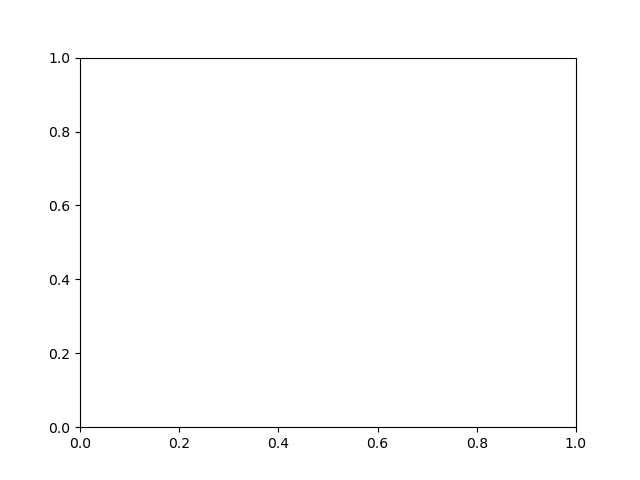

In [6]:
nonzero_coords = torch.nonzero(img_3d, as_tuple = False)
x,y = torch.meshgrid(nonzero_coords[:,0], nonzero_coords[:,1])
fig, ax = plt.subplots(1)
ax.scatter(x,y,img_3d[:,:,0], cmap='viridis', edgecolor='none')

C:\Users\XStream_Server\AppData\Local\Temp\ipykernel_14972\1110093600.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


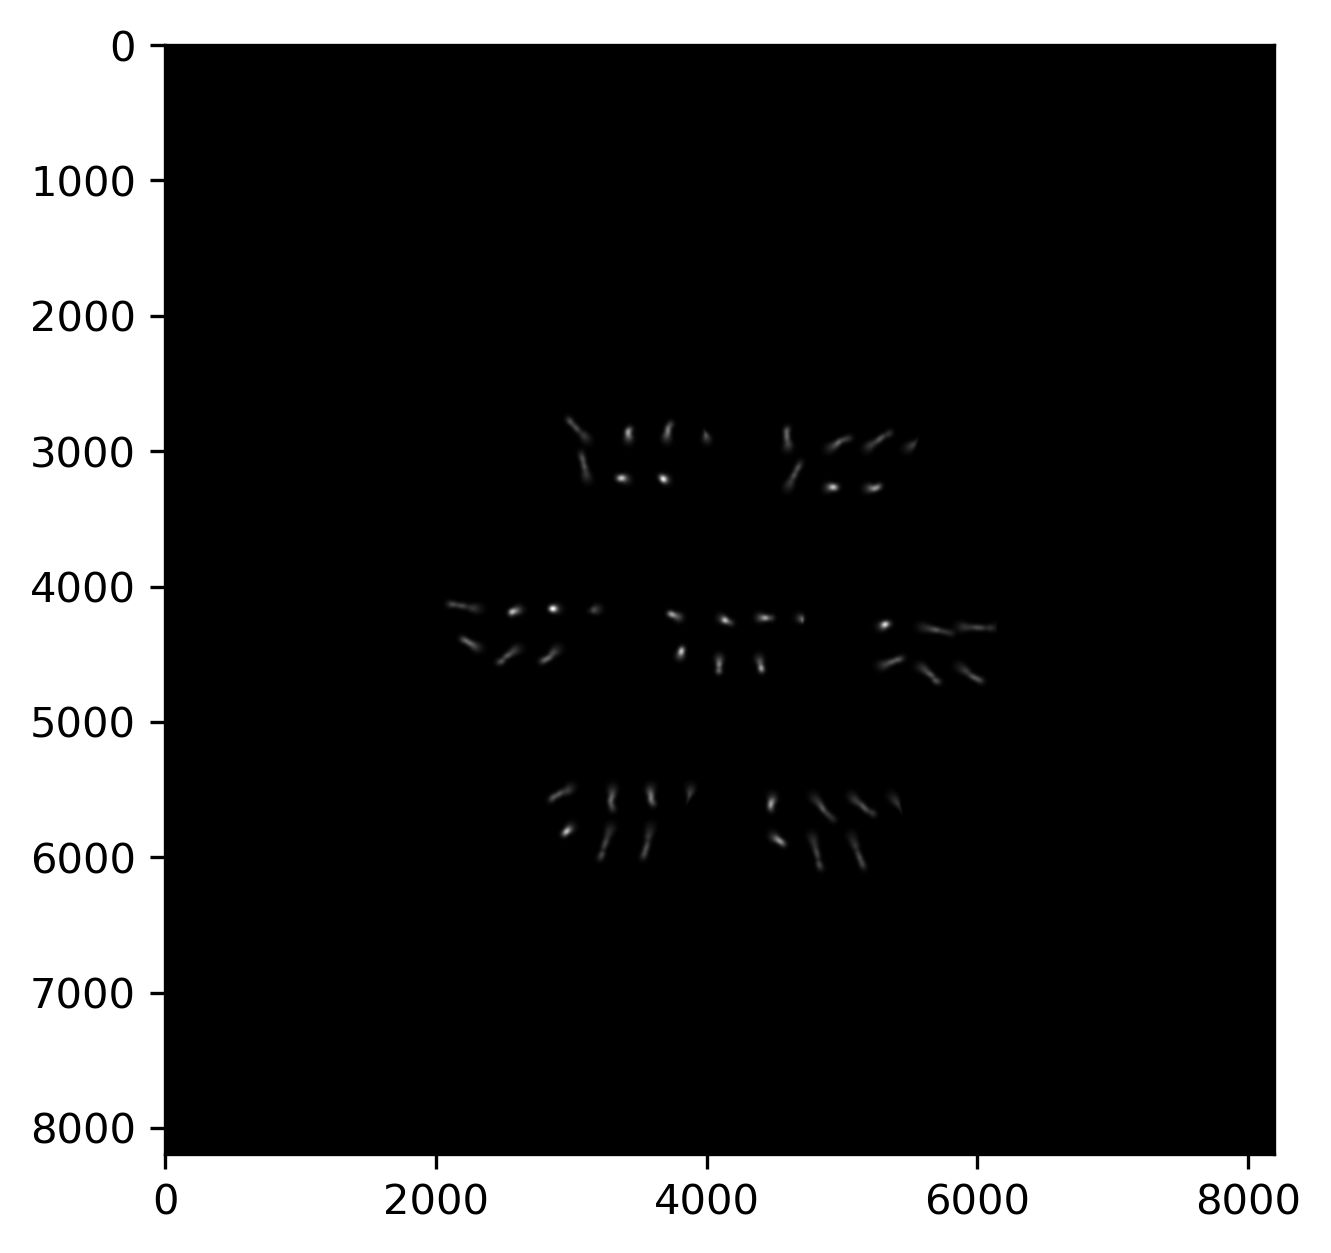

In [71]:
plt.close()
fig, ax = plt.subplots(1, 1, dpi=300)
ref = torch.load(r'./def_ref/ref_0.pt').to_dense().cpu()
ax.imshow(ref, cmap='gray')
fig.show()

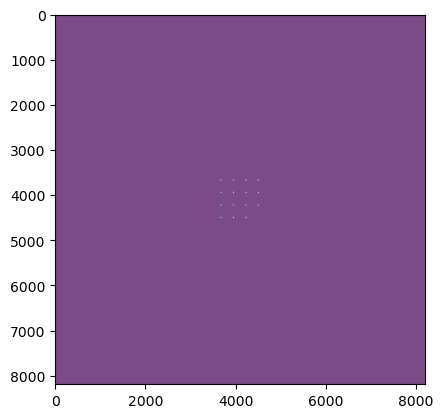

In [23]:
plt.imshow(template[0,:,:],alpha=0.3)
plt.imshow(template[10,:,:],alpha=0.4)
plt.imshow(template[20,:,:],alpha=0.3)
plt.show()